In [20]:
import pandas as pd
import numpy as np
import seaborn as sns

import os
from functools import reduce

from pyspark.sql import SparkSession, DataFrame

In [21]:
sp = SparkSession.builder.appName("Fraud detection").getOrCreate()

In [22]:
sp

In [23]:
def merge_folder(trans_group: str):
    """
    Function to merge everything within yellow or green or fhvhv
    """
    dir = "../data/tables/" + trans_group +"/"
    folder_locs = os.listdir(dir)

    group_list = []
    for folder in folder_locs:
        path = dir + "/" + folder
        if os.path.isdir(path):
            # print("At current path", path)
            group_list.append(sp.read.parquet(path))

    return reduce(DataFrame.unionAll, group_list)

In [24]:
dir = "../data/tables/"
groups = ["transactions_20210228_20210827_snapshot/", "transactions_20210828_20220227_snapshot/", "transactions_20220228_20220828_snapshot/"]

final_list = []
for g in groups:
    print("Started group: ", g)
    final_list.append(merge_folder(g))

final = reduce(DataFrame.unionAll, final_list)

Started group:  transactions_20210228_20210827_snapshot/
Started group:  transactions_20210828_20220227_snapshot/
Started group:  transactions_20220228_20220828_snapshot/


In [25]:
final.count()

14195505

In [26]:
# To make it faster to visualize
sample = final.sample(0.01)
sample.show(5)
sample.count()

+-------+------------+-----------------+--------------------+
|user_id|merchant_abn|     dollar_value|            order_id|
+-------+------------+-----------------+--------------------+
|  18516| 49549583265|998.4639005494446|4d8dd9f2-cddf-4ee...|
|     58| 45629217853|56.11154113012139|6907a3fa-cbbd-4ae...|
|    146| 94690988633|173.7370143957687|08ed08c4-6829-4d5...|
|  18634| 99291944648|697.4227875473488|aa1edeff-0e09-49d...|
|    206| 45466221547|36.78926039177087|fd90a90f-a81c-43b...|
+-------+------------+-----------------+--------------------+
only showing top 5 rows



141967

In [27]:
cFraud = sp.read.option("header", True).csv("../data/tables/consumer_fraud_probability.csv")
cFraud.show(3)
cFraud.count()

+-------+--------------+-----------------+
|user_id|order_datetime|fraud_probability|
+-------+--------------+-----------------+
|   6228|    2021-12-19| 97.6298077657765|
|  21419|    2021-12-10|99.24738020302328|
|   5606|    2021-10-17|84.05825045251777|
+-------+--------------+-----------------+
only showing top 3 rows



34864

In [28]:
mFraud = sp.read.option("header", True).csv("../data/tables/merchant_fraud_probability.csv")
mFraud.show(3)
mFraud.count()

+------------+--------------+------------------+
|merchant_abn|order_datetime| fraud_probability|
+------------+--------------+------------------+
| 19492220327|    2021-11-28|44.403658647495355|
| 31334588839|    2021-10-02| 42.75530083865367|
| 19492220327|    2021-12-22|38.867790051131095|
+------------+--------------+------------------+
only showing top 3 rows



114

In [29]:
customer_fraud = pd.read_csv("../data/tables/consumer_fraud_probability.csv")
customer_fraud.head()

,user_id,order_datetime,fraud_probability
0,6228,2021-12-19,97.629808
1,21419,2021-12-10,99.247380
2,5606,2021-10-17,84.058250
3,3101,2021-04-17,91.421921
4,22239,2021-10-19,94.703425


In [30]:
sample.select("user_id").distinct().count()

24007

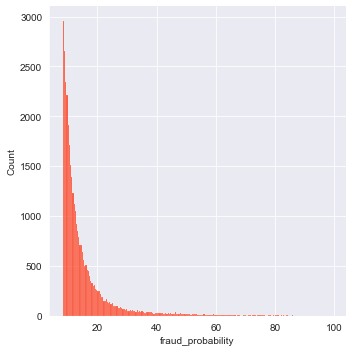

In [31]:
sns.set_style("darkgrid")
sns.set_palette("autumn")

sns.displot(customer_fraud["fraud_probability"])

In [32]:
customer_fraud[customer_fraud["fraud_probability"] > 33.33].count()

user_id              1862
order_datetime       1862
fraud_probability    1862
dtype: int64

In [33]:
customer_fraud.count()

user_id              34864
order_datetime       34864
fraud_probability    34864
dtype: int64

In [34]:
merchant_fraud = pd.read_csv("../data/tables/merchant_fraud_probability.csv")
merchant_fraud.head()

,merchant_abn,order_datetime,fraud_probability
0,19492220327,2021-11-28,44.403659
1,31334588839,2021-10-02,42.755301
2,19492220327,2021-12-22,38.867790
3,82999039227,2021-12-19,94.134700
4,90918180829,2021-09-02,43.325517


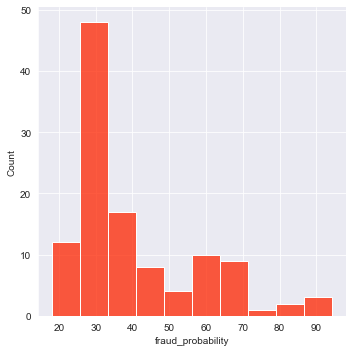

In [35]:
sns.displot(merchant_fraud["fraud_probability"])

In [36]:
merchant_fraud[merchant_fraud["fraud_probability"] < 20].count()

merchant_abn         2
order_datetime       2
fraud_probability    2
dtype: int64

In [37]:
merchant_fraud.count()

merchant_abn         114
order_datetime       114
fraud_probability    114
dtype: int64

In [38]:
merchant_fraud[merchant_fraud["fraud_probability"] > 50].count()

merchant_abn         27
order_datetime       27
fraud_probability    27
dtype: int64